In [ ]:
#################################################################################################################################
########################## ARIMA MODEL FOR HOURLY ENERGY CONSUMPTION DATA  ######################################################
#################################################################################################################################

In [1]:
# Importing important libraries 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import os
import calendar
import sys
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from prophet import Prophet 
import matplotlib as mpl
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
# Load the dataset
data = pd.read_csv('PJM(AEP)_energy_dataset.csv')

# Convert 'Datetime' column to datetime type and sort by date
data['Datetime'] = pd.to_datetime(data['Datetime'])
data = data.sort_values('Datetime')
# Set 'Datetime' as the index
data.set_index('Datetime', inplace=True)

In [3]:
data.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


In [4]:
# Look at the range of the data by date
data.index

DatetimeIndex(['2002-01-01 01:00:00', '2002-01-01 02:00:00',
               '2002-01-01 03:00:00', '2002-01-01 04:00:00',
               '2002-01-01 05:00:00', '2002-01-01 06:00:00',
               '2002-01-01 07:00:00', '2002-01-01 08:00:00',
               '2002-01-01 09:00:00', '2002-01-01 10:00:00',
               ...
               '2018-08-02 15:00:00', '2018-08-02 16:00:00',
               '2018-08-02 17:00:00', '2018-08-02 18:00:00',
               '2018-08-02 19:00:00', '2018-08-02 20:00:00',
               '2018-08-02 21:00:00', '2018-08-02 22:00:00',
               '2018-08-02 23:00:00', '2018-08-03 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

In [5]:
# Check for missing values in the DataFrame
missing_values = data.isnull().sum()
print(missing_values)
print(data.shape)

PJME_MW    0
dtype: int64
(145366, 1)


In [6]:
# Summary of the data set
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PJME_MW,145366.0,32080.222831,6464.012166,14544.0,27573.0,31421.0,35650.0,62009.0


In [7]:
################## Visualising the distribution of the data #############################
#################  And numerical distribution of the data ################################

<Axes: title={'center': 'Distribution of Power consumption in MW'}, ylabel='Frequency'>

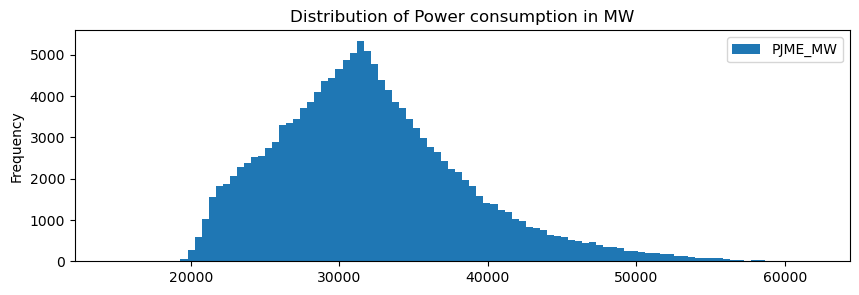

In [8]:
# Histogram to show the distribution of the hourly power consumption data
data.plot.hist(figsize=(10, 3), bins=100, title='Distribution of Power consumption in MW')

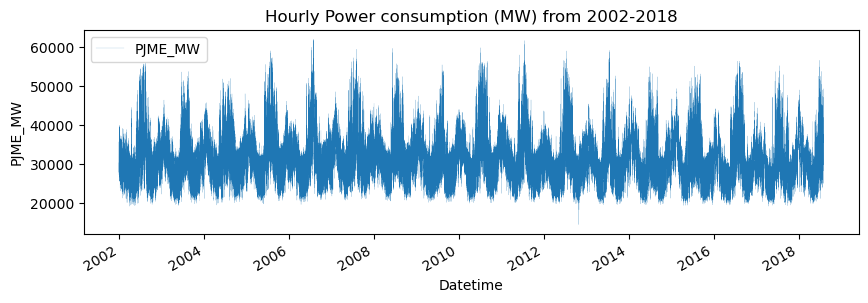

In [9]:
## Ploting the time series data of hourly power consumption across all years 2002-2018style='.',
plot=data.plot( figsize=(10, 3), title='Hourly Power consumption (MW) from 2002-2018', linewidth=0.1)
# Label the y-axis
plt.ylabel('PJME_MW')
# Show the plot
plt.show()


In [10]:
### Preparing the data. Fucntion to prepare data for ARIMA and PROPHET  split the data into training and test set, 
def convert_to_prophet(data):
    data=data.reset_index()
    data.columns=['ds', 'y']
    data.index=data.ds
    data.index.names=['datetimeIndex']
    return data
def get_train_test_generic(for_prophet=False, freq=None):
    df=data
    
    if freq is not None:
        df = df[['PJME_MW']].resample(freq).sum()
    train_len = int(.7*len(df))
    train_df = df.iloc[:train_len].copy()
    test_df = df.iloc[train_len:].copy()

    if for_prophet:
        df=convert_to_prophet(df)
        train_df=convert_to_prophet(train_df)
        test_df=convert_to_prophet(test_df)
    return train_df, test_df, df

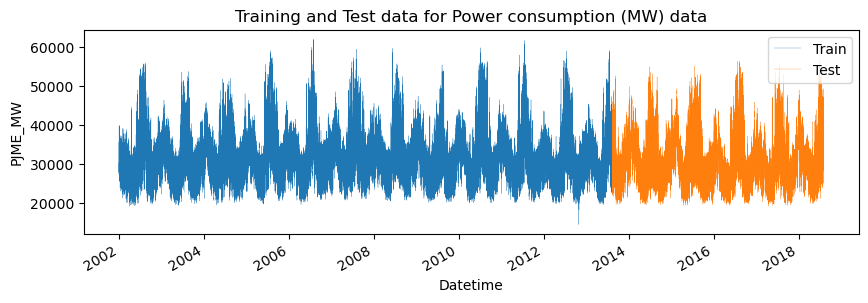

(101756, 1)
(43610, 1)


In [11]:
### Training test split 70% train and 30% test set
tr_df, te_df, df=get_train_test_generic()
from pylab import rcParams
rcParams['figure.figsize']=10,3
tr_df['PJME_MW'].plot(label='Train', legend=True, linewidth=0.2)
te_df['PJME_MW'].plot(label='Test', legend=True, linewidth=0.2)
plt.title('Training and Test data for Power consumption (MW) data')
# Label the y-axis
plt.ylabel('PJME_MW')
plt.show()
print(tr_df.shape)
print(te_df.shape)

In [12]:
display(tr_df)
display(te_df)

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2013-08-11 16:00:00,38056.0
2013-08-11 17:00:00,39099.0
2013-08-11 18:00:00,39749.0


,PJME_MW
Datetime,
2013-08-11 21:00:00,38265.0
2013-08-11 22:00:00,37127.0
2013-08-11 23:00:00,34604.0
2013-08-12 00:00:00,31721.0
2013-08-12 01:00:00,29447.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


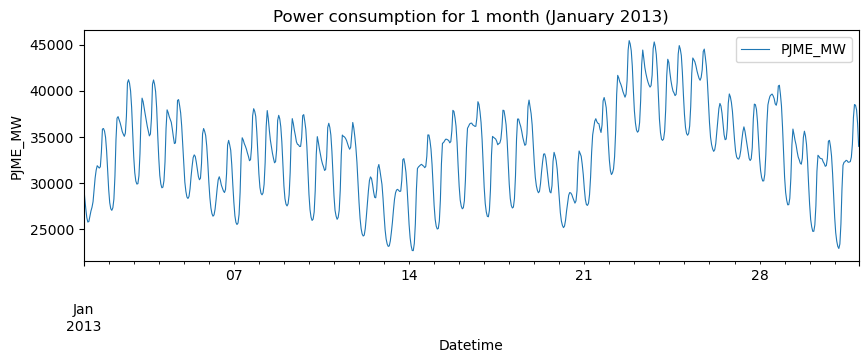

In [14]:
## Closser look at power consumption for 1 month (January 2017)

df.loc[(df.index.year==2013) & (df.index.month==1)].plot(figsize=(10, 3), 
                                                         title='Power consumption for 1 month (January 2013)', linewidth=0.8)
# Label the y-axis
plt.ylabel('PJME_MW')
plt.show()

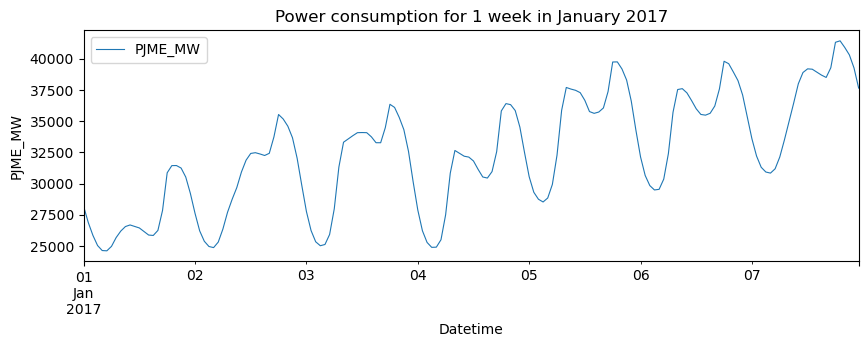

In [15]:
## Closser look at power consumption for 1 week in January 2017             rot=90
single_week=(df.index.year==2017) & (df.index.month==1) & ((df.index.day==1) | (df.index.day<=7)) 
df.loc[single_week].plot(figsize=(10, 3), 
                         title='Power consumption for 1 week in January 2017', linewidth=0.8)
# Label the y-axis
plt.ylabel('PJME_MW')
plt.show()

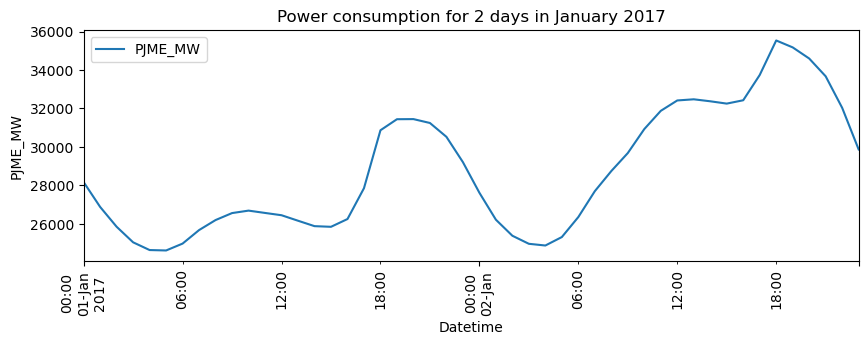

In [16]:
## Closser look at power consumption for 2 days in January 2017
single_week=(df.index.year==2017) & (df.index.month==1) & ((df.index.day==1) | (df.index.day==2))
df.loc[single_week].plot(figsize=(10, 3), 
                         title='Power consumption for 2 days in January 2017', rot=90)
# Label the y-axis
plt.ylabel('PJME_MW')
plt.show()

In [114]:
################################## Time Series Decomposition ####################################################

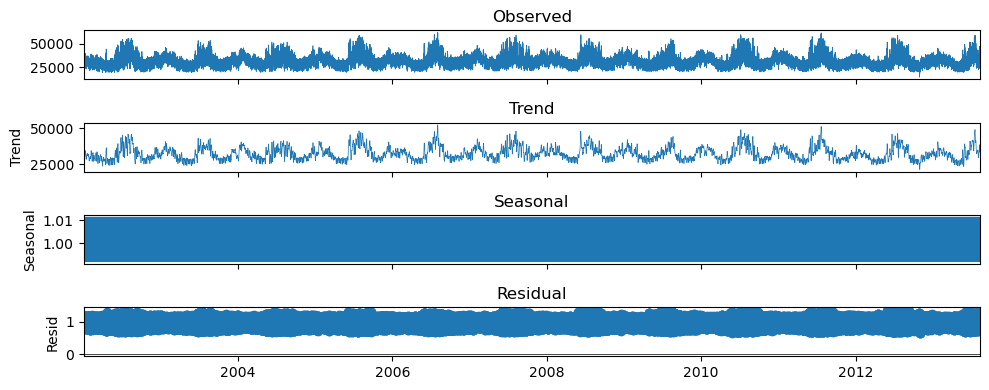

In [17]:
# Decomposing the time series of the training data set shows very dense seasonality 
result = seasonal_decompose(tr_df[['PJME_MW']], period=48, model='mul')
rcParams['figure.figsize']=10,4
# Plot the decomposition results with reduced line width
fig = result.plot()
for ax, title in zip(fig.axes, ['Observed', 'Trend', 'Seasonal', 'Residual']):
    for line in ax.get_lines():
        line.set_linewidth(0.5)  # Set line width to 0.5
    ax.set_title(title)  # Set title for each subplot

plt.tight_layout()
plt.show()
# It is better to zoom in and look at weekly or monthly

,PJME_MW
Datetime,
2013-01-07 00:00:00,27906.0
2013-01-07 01:00:00,26436.0
2013-01-07 02:00:00,25709.0
2013-01-07 03:00:00,25488.0
2013-01-07 04:00:00,25652.0


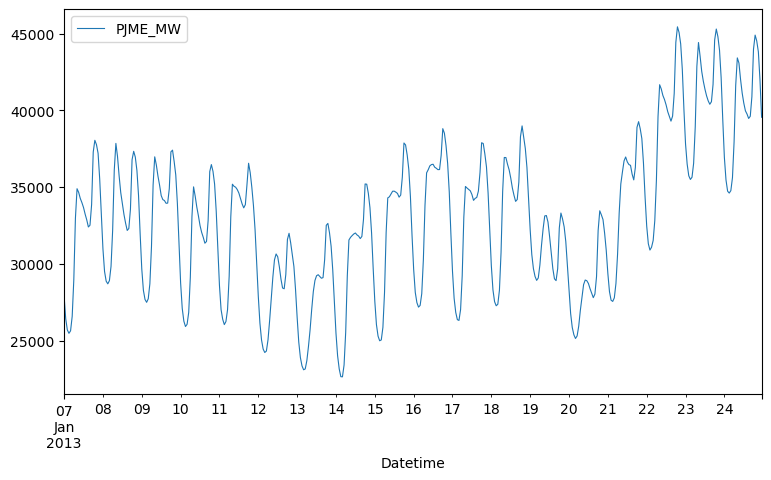

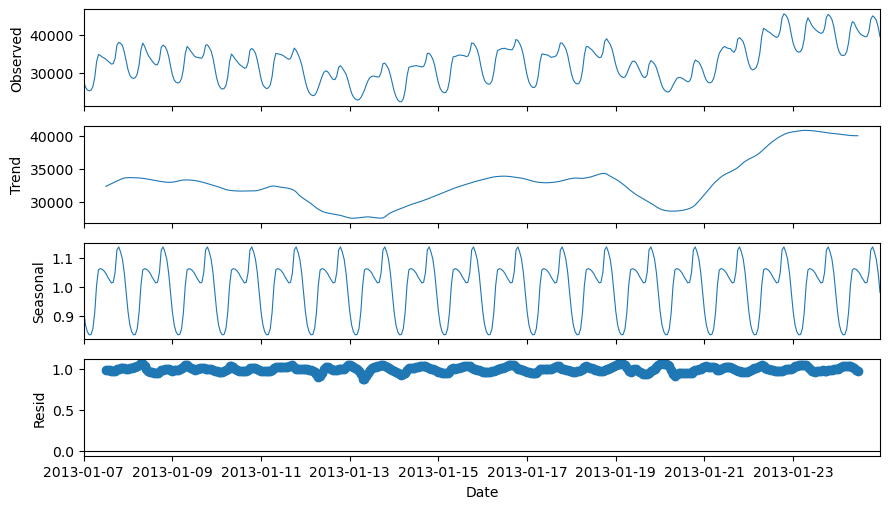

In [30]:
## Daily seasonality within a week decomposition   14             20
tr_sub=tr_df.loc[(tr_df.index >= '2013-01-07') & (tr_df.index < '2013-01-25')]
display(tr_sub.head())
tr_sub=tr_sub.sort_index()
tr_sub.plot(linewidth=0.8)
result=seasonal_decompose(tr_sub, period=24, model='mult')

# Adjust figure size for decomposition plots
rcParams['figure.figsize'] = (9, 5)

# Plot the decomposition with thinner lines
fig = result.plot()
for ax in fig.axes:
    if ax is fig.axes[-1]:  # Label the x-axis
        ax.set_xlabel('Date')
    if ax is fig.axes[0]:  # label the y-axis in on the first plot
        ax.set_ylabel('Observed') 
    for line in ax.get_lines():
        line.set_linewidth(0.8)  # Adjust line width here (thinner)

plt.show()

#rcParams['figure.figsize']=9, 5
#fig=result.plot()
# We can see daily seasonality within the week. The trend is moving upwards.

,PJME_MW
Datetime,
2013-01-05 00:00:00,31915.0
2013-01-05 01:00:00,30094.0
2013-01-05 02:00:00,29085.0
2013-01-05 03:00:00,28471.0
2013-01-05 04:00:00,28314.0


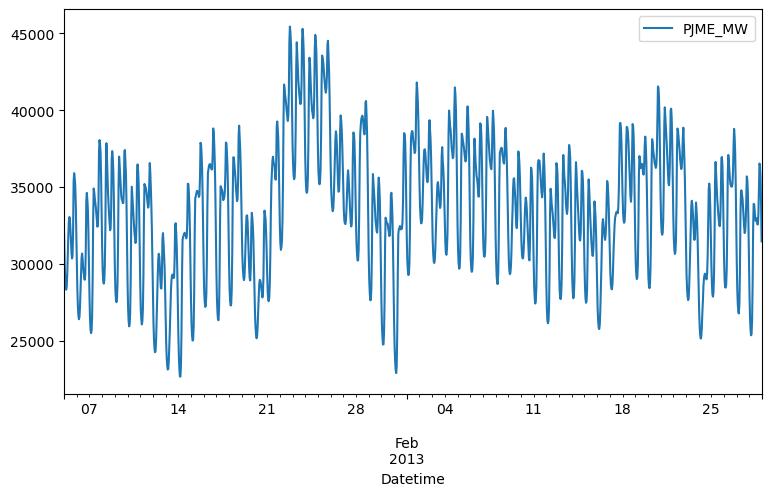

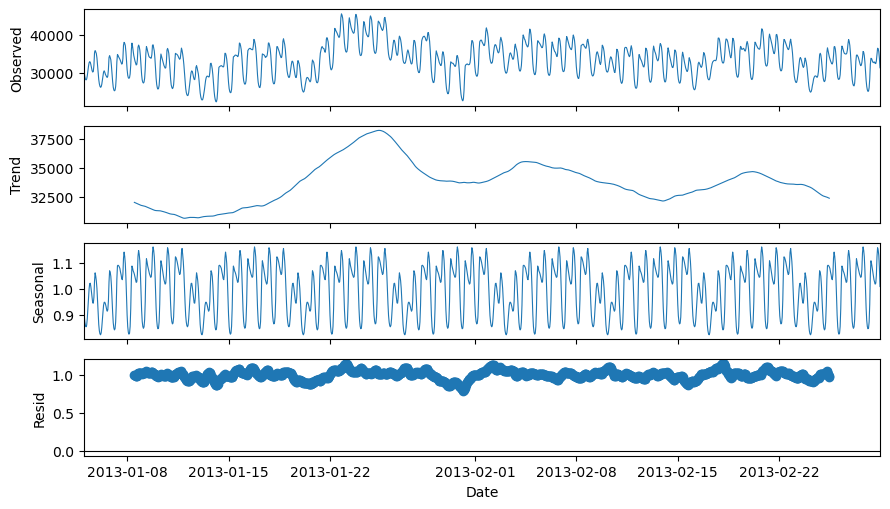

In [45]:
## Weekly Seasonality within a month 07           03
tr_sub = tr_df.loc[(tr_df.index >= '2013-01-05') & (tr_df.index < '2013-03-01')]
display(tr_sub.head())
tr_sub=tr_sub.sort_index()
tr_sub.plot()
result=seasonal_decompose(tr_sub, period=168, model='mult')

# Adjust figure size for decomposition plots
rcParams['figure.figsize'] = (9, 5)

# Plot the decomposition with thinner lines
fig = result.plot()
for ax in fig.axes:
    if ax is fig.axes[-1]:  # Check if it's the last axis (bottom plot)
        ax.set_xlabel('Date')
    if ax is fig.axes[0]:  # label the y-axis in on the first plot
        ax.set_ylabel('Observed')
    for line in ax.get_lines():
        line.set_linewidth(0.8)  # Adjust line width here (thinner)

plt.show()
#rcParams['figure.figsize']=10, 4
#fig=result.plot()
# Shows in the weekends power consumption decreases and increases within weekdays.

,PJME_MW
Datetime,
2010-01-01 00:00:00,31647.0
2010-01-01 01:00:00,30075.0
2010-01-01 02:00:00,28907.0
2010-01-01 03:00:00,27906.0
2010-01-01 04:00:00,27373.0


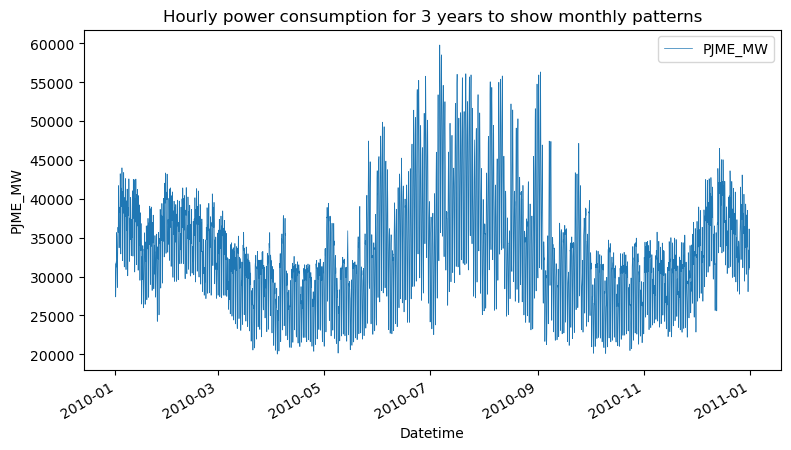

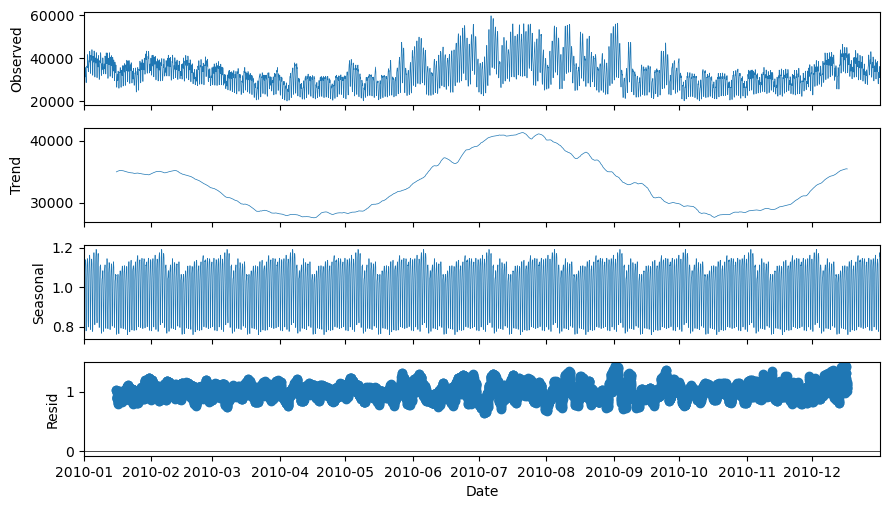

In [118]:
## We look at monthly seasonality within a year
# Extract one year of hourly data
tr_sub=tr_df.loc[(tr_df.index >= '2010-01-01') & (tr_df.index < '2011-01-01')]
rcParams['figure.figsize'] = (9, 5)
display(tr_sub.head())
tr_sub=tr_sub.sort_index()
tr_sub.plot(linewidth=0.5)
# Label the y-axis
plt.title('Hourly power consumption for 3 years to show monthly patterns')
plt.ylabel('PJME_MW')
plt.show()
# period=720 corresponds to one month of hourly data
result = seasonal_decompose(tr_sub, period=720, model='multiplicative')

# Adjust figure size for decomposition plots
rcParams['figure.figsize'] = (9, 5)

# Plot the decomposition with thinner lines
fig = result.plot()
for ax in fig.axes:
    if ax is fig.axes[-1]:  # Check if it's the last axis (bottom plot)
        ax.set_xlabel('Date')
    if ax is fig.axes[0]:  # label the y-axis in on the first plot
        ax.set_ylabel('Observed')
    for line in ax.get_lines():
        line.set_linewidth(0.5)  # Thinner lines for decomposition plots

plt.show()

Datetime
2002-01-01    31080.739130
2002-01-02    34261.541667
2002-01-03    34511.875000
2002-01-04    33715.458333
2002-01-05    30405.125000
Freq: D, Name: PJME_MW, dtype: float64

(6059,)


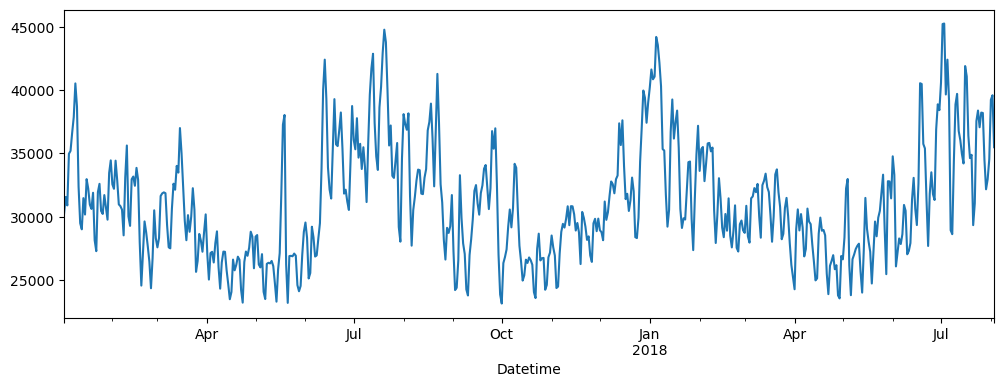

In [119]:
#########################################################################################
### B.  Aggregate the data at the daily, weekly and monthly levels and analyse
### ####################################################################################
# 1. Daily average 
daily_df=df['PJME_MW'].resample('1D').mean()
display(daily_df.head())
rcParams['figure.figsize']=12, 4
daily_df.loc[daily_df.index > '2017'].plot()
print(daily_df.shape)

Datetime
2002-01-01    32527.491018
2002-01-08    31240.119048
2002-01-15    31571.732143
2002-01-22    29720.517857
2002-01-29    29635.892857
Freq: 7D, Name: PJME_MW, dtype: float64

(866,)


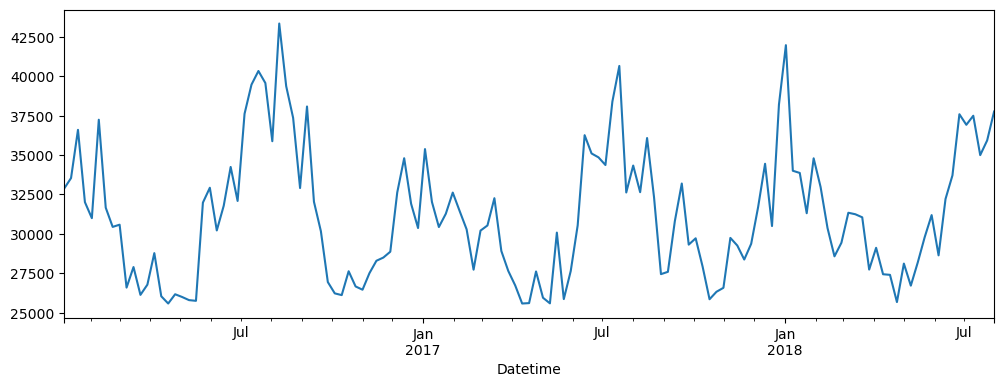

In [120]:
# 2. Weekly average 
weekly_df=df['PJME_MW'].resample('7D').mean()
display(weekly_df.head())
rcParams['figure.figsize']=12, 4
weekly_df.loc[weekly_df.index > '2016'].plot()
print(weekly_df.shape)

Datetime
2002-01-31    31075.399731
2002-02-28    30239.166667
2002-03-31    28875.256720
2002-04-30    28534.731572
2002-05-31    28073.653226
Freq: ME, Name: PJME_MW, dtype: float64

(200,)


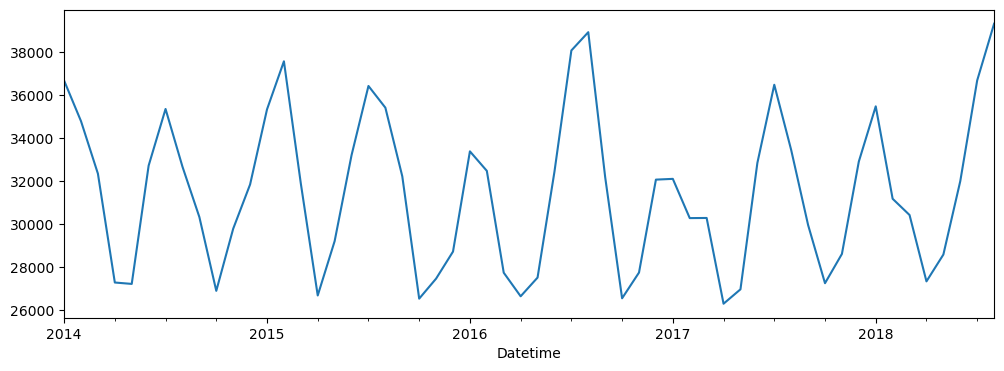

In [121]:
# 3. Monthly average 
monthly_df=df['PJME_MW'].resample('1M').mean()
display(monthly_df.head())
rcParams['figure.figsize']=12, 4
monthly_df.loc[monthly_df.index > '2014'].plot()
print(monthly_df.shape)

In [122]:
##################################################################################################################
####################### Useful Validation metrices and plots ##############################

In [123]:
## Function to calculate mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
## Function to plot the train set, test set and their predictions and also include the performance metric 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def validate_1(test_df, pred_df, var):
    pred_res = pred_df[var]
    test = test_df[var]
    mse = mean_squared_error(pred_res, test)
    rmse = mean_squared_error(pred_res, test, squared=False)
    mae = mean_absolute_error(pred_res, test)
    mape = mean_absolute_percentage_error(pred_res, test)
    print("mse={:.3f}, rmse={:.3f}, mae={:.3f}, mape={:.3f}".format(mse, rmse, mae, mape))
    return mse, rmse, mae, mape

#make sure the index is datetime variable
def plot_and_validate_1(train_df, test_df, pred_df, var):
    rcParams['figure.figsize'] = 10,3
    train_df[var].plot(label='Train', legend=True, linewidth=1) 
    test_df[var].plot(label='Test', legend=True, linewidth=1)
    pred_df[var].plot(label='Pred', legend=True, linewidth=1)
    validate(test_df, pred_df, var)

def smape_func(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f)))

def validate(test_df, pred_df, te_var, pred_var):
    merged = test_df.merge(pred_df, left_index=True, right_index=True)
    pred_res = merged[te_var] 
    test = merged[pred_var]
    mse = mean_squared_error(pred_res, test)
    rmse = mean_squared_error(pred_res, test, squared=False)
    mae = mean_absolute_error(pred_res, test)
    mape = mean_absolute_percentage_error(pred_res, test)
    smape = smape_func(test, pred_res)
    print("mse={:.3f}, rmse={:.3f}, mae={:.3f}, mape={:.3f}, smape={:.3f}".format(mse, rmse, mae, mape, smape))
    return mse, rmse, mae, mape, smape

#make sure the index is datetime variable
def plot_and_validate(train_df, test_df, pred_df, te_var, pred_var):
    rcParams['figure.figsize']=12,4
    train_df[te_var].plot(label='Train', legend=True, linewidth=1) 
    merged = test_df.merge(pred_df, left_index=True, right_index=True)
    merged[te_var].plot(label='Test', legend=True, linewidth=1)
    merged[pred_var].plot(label='Pred', legend=True, linewidth=1)
    # Adding labels and title
    plt.xlabel('DateTime')
    plt.ylabel(te_var)
    plt.title(f'Train, Test, and Predicted values for {te_var}')
    
    validate(test_df, pred_df, te_var, pred_var)
    plt.show()
    #validate(test_df, pred_df, te_var, pred_var)

[1.         0.97476421 0.90751158 0.81247953 0.70185988 0.58636027
 0.47642875 0.38105031 0.30595252 0.25264093 0.21832143 0.1980471
 0.18851645 0.18917872 0.20069852 0.22632964 0.27085645 0.33694112
 0.42299609 0.52321889 0.6286453  0.72901079 0.81400307 0.87233639
 0.89121166 0.86322437 0.795731   0.70164138 0.59246237 0.47868245
 0.37057971 0.27690367 0.20309156 0.1504664  0.11639705 0.09621051
 0.086676   0.08719917 0.09848814 0.12370551 0.16734466 0.23190083
 0.31593458 0.41386879 0.51686472 0.61470246 0.69717236 0.75357101
 0.77232415 0.74680449 0.6836447  0.59456926]


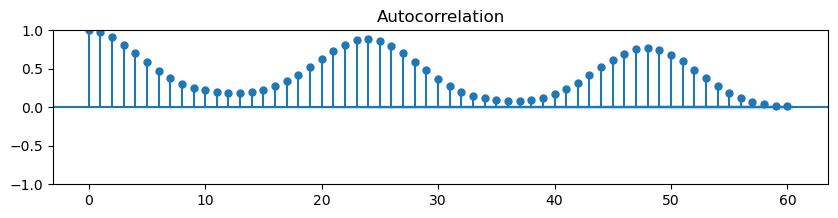

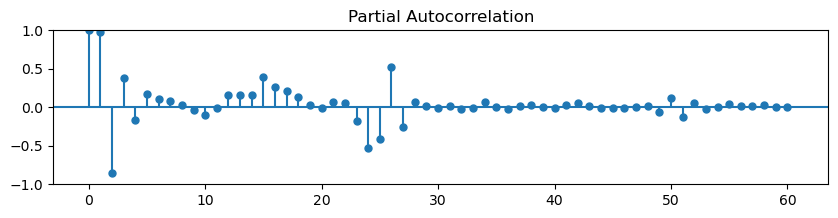

In [124]:
############# Autocorrelation plots #####################################################
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. On hourly power consumption 
### Autocorrelation plot and partial autocorrelation 
print(acf(df['PJME_MW']))
rcParams['figure.figsize']=10,2
# Plot ACF
plot_acf(df['PJME_MW'], lags=60)
plt.show()
# Plot PACF
plot_pacf(df['PJME_MW'], lags=60)
plt.show()

In [32]:
############################# ARIMA MODELLING ################################################################################

In [125]:
#### 1. On hourly power consumption   
## To model the hourly power consumption using ARIMA is not possible given the size of the trainning set
## So I will consider only a small portion of the data.
new=df.tail(3500)
# Split the data into training and testing sets (70:30)
trn_size = int(len(new) * 0.7)
tr_df, te_df = new.iloc[:trn_size], new.iloc[trn_size:]
print(tr_df.shape)
print(te_df.shape)
print(tr_df.head())     

(2450, 1)
(1050, 1)
                     PJME_MW
Datetime                    
2018-03-10 04:00:00  28242.0
2018-03-10 05:00:00  28592.0
2018-03-10 06:00:00  29485.0
2018-03-10 07:00:00  30599.0
2018-03-10 08:00:00  31219.0


[ 1.          0.96816535  0.88295057  0.76368785  0.62785755  0.48968431
  0.36176832  0.25451583  0.17415184  0.120698    0.08739081  0.06562664
  0.05114888  0.04374825  0.04423979  0.05697163  0.09022768  0.15037813
  0.23717215  0.34415973  0.46090584  0.5751459   0.67358333  0.74074133
  0.75999143  0.72283832  0.63805536  0.52292156  0.39347908  0.26302301
  0.14324352  0.04361543 -0.03047139 -0.07948004]


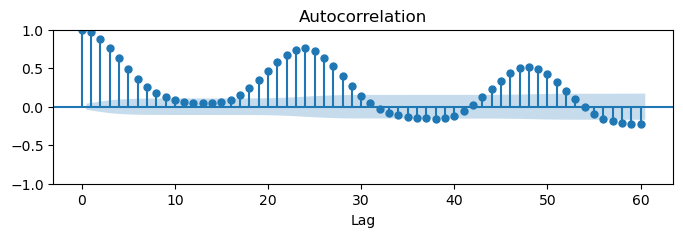

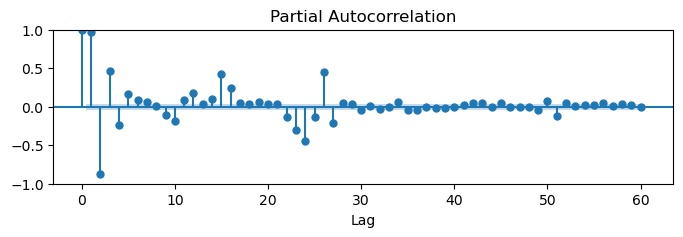

In [126]:
# 1. On hourly power consumption 
### Autocorrelation plot and partial autocorrelation 
print(acf(tr_df['PJME_MW']))
rcParams['figure.figsize']=8,2
# Plot ACF
plot_acf(tr_df['PJME_MW'], lags=60)
plt.xlabel('Lag')
plt.show()
# Plot PACF
plot_pacf(tr_df['PJME_MW'], lags=60)
plt.xlabel('Lag')
plt.show()

In [60]:
import pmdarima as pm
model_hourly = pm.auto_arima(tr_df['PJME_MW'], seasonal=True, m=24, trace=True, njobs=-1)
# Display the model summary
print(model_hourly.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=21.96 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=41727.146, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=4.62 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=37656.382, Time=4.44 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=41725.147, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=39364.120, Time=0.48 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=35824.543, Time=15.39 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=36158.719, Time=6.00 sec
 ARIMA(0,1,1)(2,0,1)[24] intercept   : AIC=inf, Time=35.07 sec
 ARIMA(0,1,1)(1,0,2)[24] intercept   : AIC=inf, Time=45.15 sec
 ARIMA(0,1,1)(0,0,2)[24] intercept   : AIC=37072.418, Time=21.83 sec
 ARIMA(0,1,1)(2,0,0)[24] intercept   : AIC=36108.895, Time=24.78 sec
 ARIMA(0,1,1)(2,0,2)[24] intercept   : AIC=inf, Time=51.10 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=10.79 sec
 ARIMA(1,1,1)(1,0,1)[24] intercep

mse=382709925.110, rmse=19562.973, mae=17210.524, mape=0.457, smape=0.636


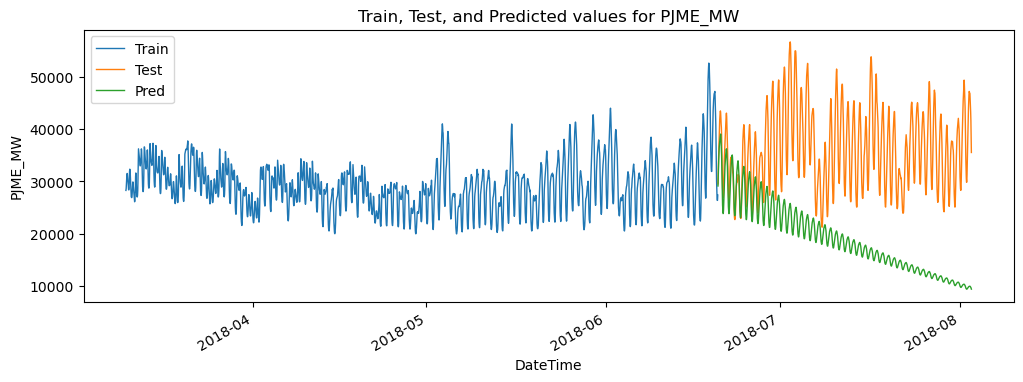

In [71]:
# Plotting the performance of the model 
predictions=model_hourly.predict(n_periods=len(te_df))
pred_df=pd.DataFrame(predictions, columns=['PRED'])
pred_df.index=te_df.index
plot_and_validate(tr_df, te_df, pred_df, 'PJME_MW', 'PRED')

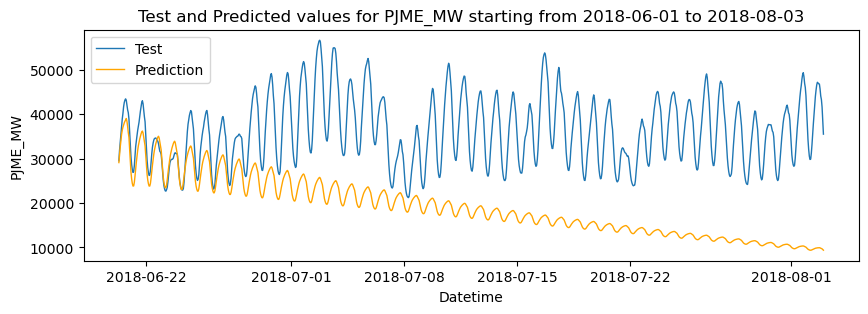

In [73]:
 # Plotting the slices of test and prediction data from '2018-06-01'
# Filter the data for the desired date range
test_data = te_df.loc['2018-06-01':]
pred_data = pred_df.loc['2018-06-01':]

# Plotting
rcParams['figure.figsize'] = 10, 3
plt.plot(test_data.index, test_data, label='Test', linewidth=1)
plt.plot(pred_data.index, pred_data, label='Prediction', color='orange', linewidth=1)
# Adding y-axis label and title
plt.ylabel('PJME_MW')
plt.xlabel('Datetime')
plt.title('Test and Predicted values for PJME_MW starting from 2018-06-01 to 2018-08-03')
# Adding legend
plt.legend()
# Show plot
plt.show()

In [ ]:
################################################################################################################################
##                                                                                                                            ##
##                                         USING PROPHET TO FORECAST HOURLY POWER CONSUMPTION                                 ##
##                                                                                                                            ##
################################################################################################################################

In [81]:
## Function to calculate mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
## Function to plot the train set, test set and their predictions and also include the performance metric  
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def validate_1(test_df, pred_df, var):
    pred_res = pred_df[var]
    test = test_df[var]
    mse = mean_squared_error(pred_res, test)
    rmse = mean_squared_error(pred_res, test, squared=False)
    mae = mean_absolute_error(pred_res, test)
    mape = mean_absolute_percentage_error(pred_res, test)
    print("mse={:.3f}, rmse={:.3f}, mae={:.3f}, mape={:.3f}".format(mse, rmse, mae, mape))
    return mse, rmse, mae, mape

#make sure the index is datetime variable
def plot_and_validate_1(train_df, test_df, pred_df, var):
    rcParams['figure.figsize'] = 10,3
    train_df[var].plot(label='Train', legend=True, linewidth=0.5) 
    test_df[var].plot(label='Test', legend=True, linewidth=0.5)
    pred_df[var].plot(label='Pred', legend=True, linewidth=0.5)
    validate(test_df, pred_df, var)

def smape_func(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f)))

def validate(test_df, pred_df, te_var, pred_var):
    merged = test_df.merge(pred_df, left_index=True, right_index=True)
    pred_res = merged[te_var] 
    test = merged[pred_var]
    mse = mean_squared_error(pred_res, test)
    rmse = mean_squared_error(pred_res, test, squared=False)
    mae = mean_absolute_error(pred_res, test)
    mape = mean_absolute_percentage_error(pred_res, test)
    smape = smape_func(test, pred_res)
    print("mse={:.3f}, rmse={:.3f}, mae={:.3f}, mape={:.3f}, smape={:.3f}".format(mse, rmse, mae, mape, smape))
    return mse, rmse, mae, mape, smape

#make sure the index is datetime variable
def plot_and_validate(train_df, test_df, pred_df, te_var, pred_var):
    rcParams['figure.figsize']=12,4
    train_df[te_var].plot(label='Train', legend=True, linewidth=0.5) 
    merged = test_df.merge(pred_df, left_index=True, right_index=True)
    merged[te_var].plot(label='Test', legend=True, linewidth=0.5)
    merged[pred_var].plot(label='Pred', legend=True, linewidth=0.5)
    # Adding labels and title
    plt.xlabel('DateTime')
    plt.ylabel(te_var)
    plt.title(f'Train, Test, and Predicted values for {te_var}')
    
    validate(test_df, pred_df, te_var, pred_var)
    plt.show()
    #validate(test_df, pred_df, te_var, pred_var)

In [74]:
# Sampling for prophet daily sample 
tr_df, te_df, df=get_train_test_generic(for_prophet=True, freq=None)
print(df.shape)
print(tr_df.shape)
print(te_df.shape)
print(tr_df.head())

(145366, 2)
(101756, 2)
(43610, 2)
                                     ds        y
datetimeIndex                                   
2002-01-01 01:00:00 2002-01-01 01:00:00  30393.0
2002-01-01 02:00:00 2002-01-01 02:00:00  29265.0
2002-01-01 03:00:00 2002-01-01 03:00:00  28357.0
2002-01-01 04:00:00 2002-01-01 04:00:00  27899.0
2002-01-01 05:00:00 2002-01-01 05:00:00  28057.0


13:01:33 - cmdstanpy - INFO - Chain [1] start processing
13:02:35 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-08-11 21:00:00,31332.727338,34231.497400,43359.021350,31332.727338,31332.727338,7601.843813,7601.843813,7601.843813,3716.411952,...,-1715.983939,-1715.983939,-1715.983939,5601.415801,5601.415801,5601.415801,0.0,0.0,0.0,38934.571151
1,2013-08-11 22:00:00,31332.682405,33168.423507,41713.452863,31332.682405,31332.682405,6147.344884,6147.344884,6147.344884,2105.718597,...,-1555.090245,-1555.090245,-1555.090245,5596.716532,5596.716532,5596.716532,0.0,0.0,0.0,37480.027290
2,2013-08-11 23:00:00,31332.637473,30940.737336,39917.736645,31332.637473,31332.637473,4102.881282,4102.881282,4102.881282,-97.242785,...,-1391.885242,-1391.885242,-1391.885242,5592.009309,5592.009309,5592.009309,0.0,0.0,0.0,35435.518755
3,2013-08-12 00:00:00,31332.592540,28951.206549,37919.787364,31332.592540,31332.592540,1932.395258,1932.395258,1932.395258,-2427.561755,...,-1227.337057,-1227.337057,-1227.337057,5587.294070,5587.294070,5587.294070,0.0,0.0,0.0,33264.987799
4,2013-08-12 01:00:00,31332.547608,26848.583675,35868.945844,31332.547608,31332.547608,50.897294,50.897294,50.897294,-4469.268911,...,-1062.404545,-1062.404545,-1062.404545,5582.570750,5582.570750,5582.570750,0.0,0.0,0.0,31383.444902


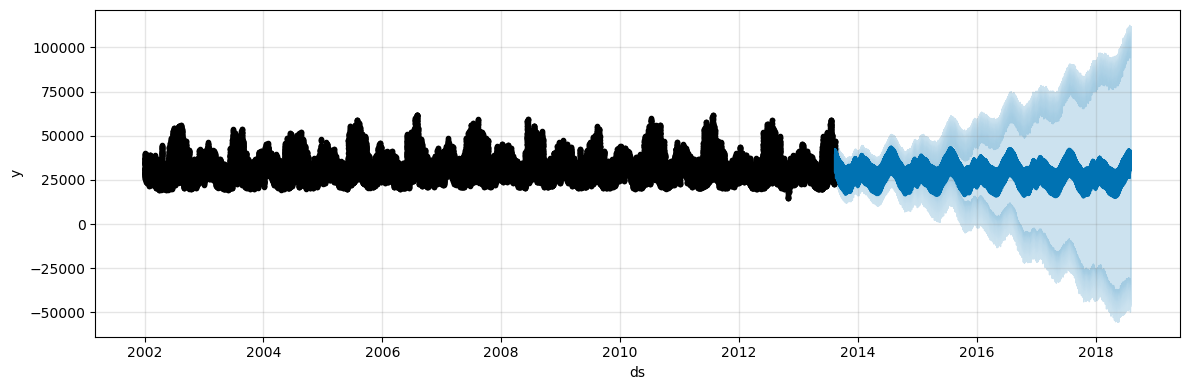

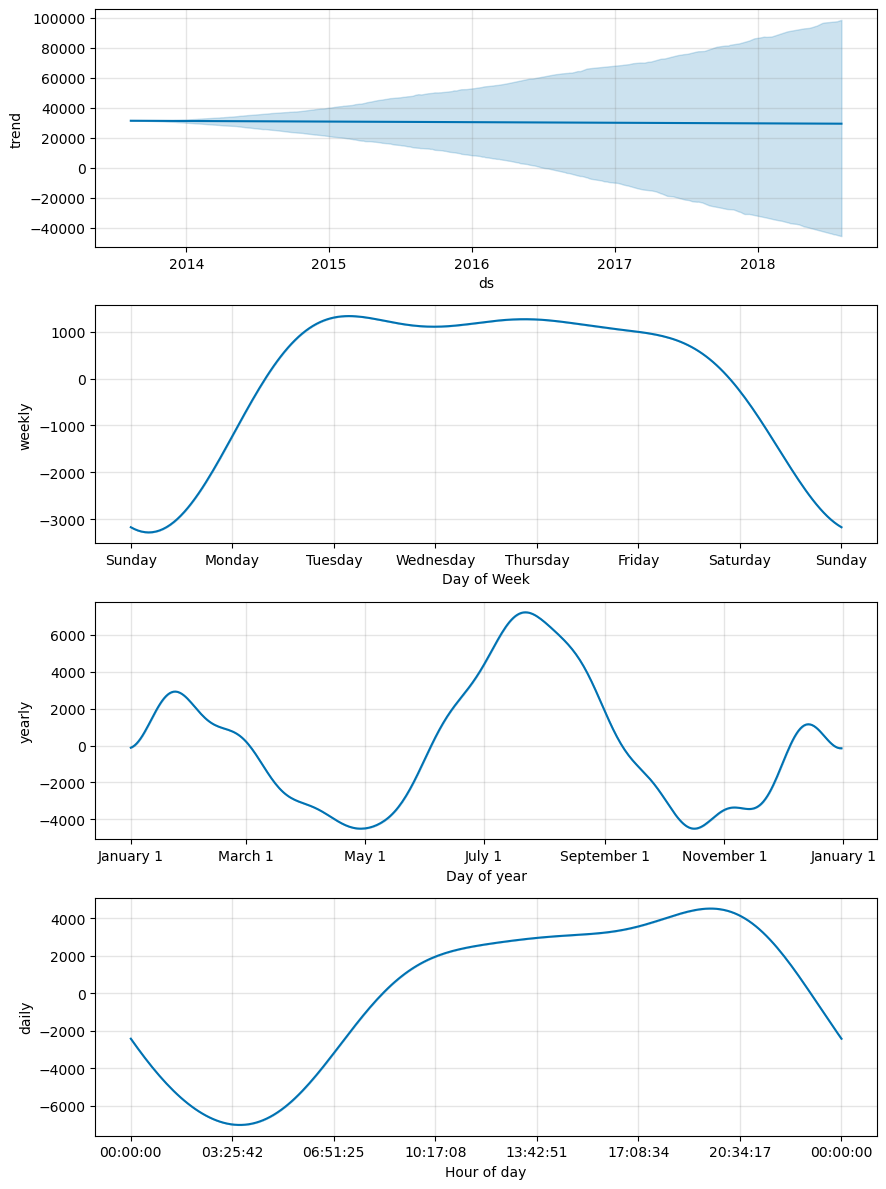

In [75]:
## Using hourly power consumption
model_prophet=Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
model_prophet.fit(tr_df)
future=model_prophet.make_future_dataframe(periods=len(te_df), freq='H', include_history=False)
prediction=model_prophet.predict(future)
fig=model_prophet.plot(prediction, figsize=(12, 4))
display(prediction.head())
model_prophet.plot_components(prediction);

In [79]:
prediction.head()
prediction.index=prediction.ds

mse=17119166.223, rmse=4137.531, mae=3093.057, mape=0.096, smape=0.099


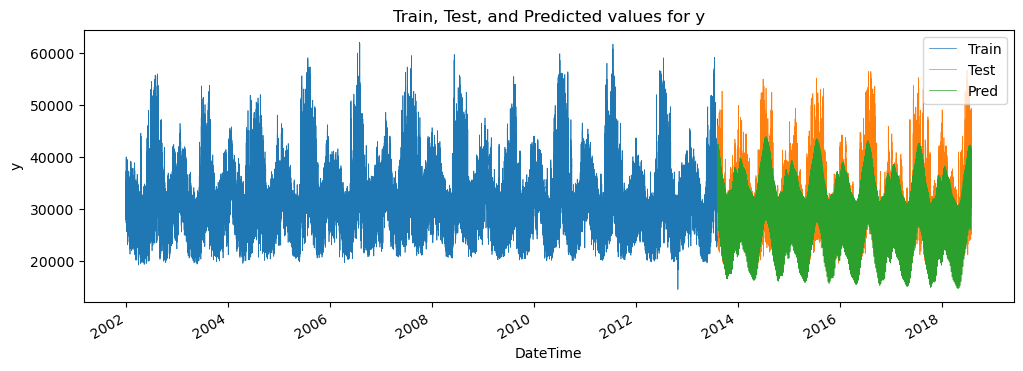

In [82]:
prediction.index=prediction.ds
plot_and_validate(tr_df, te_df, prediction, 'y', 'yhat')

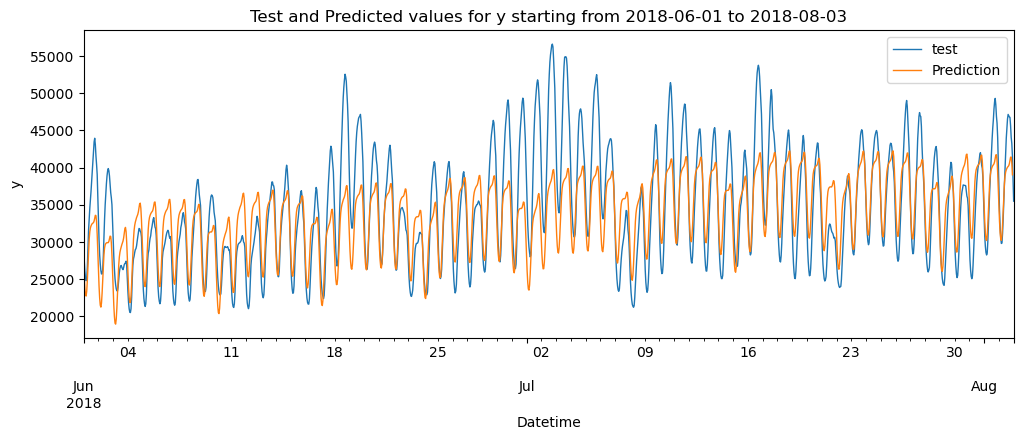

In [83]:
## We have a closer look (zoom in) on part of the predictions
te_df.loc['2018-06-01':]['y'].plot(legend=True, label='test', linewidth=1)
prediction.loc['2018-06-01':]['yhat'].plot(legend=True, label='Prediction', linewidth=1)
# Adding y-axis label and title
plt.ylabel('y')
plt.xlabel('Datetime')
plt.title('Test and Predicted values for y starting from 2018-06-01 to 2018-08-03')
# Adding legend
plt.legend()
# Show plot
plt.show()

13:16:52 - cmdstanpy - INFO - Chain [1] start processing
13:18:12 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-08-11 21:00:00,31324.087184,34687.629624,43366.648602,31324.087184,31324.087184,7829.392404,7829.392404,7829.392404,3716.409208,...,-1715.824280,-1715.824280,-1715.824280,5645.455894,5645.455894,5645.455894,0.0,0.0,0.0,39153.479588
1,2013-08-11 22:00:00,31324.041776,33166.787978,41879.580200,31324.041776,31324.041776,6376.876197,6376.876197,6376.876197,2105.757783,...,-1554.912945,-1554.912945,-1554.912945,5640.735860,5640.735860,5640.735860,0.0,0.0,0.0,37700.917973
2,2013-08-11 23:00:00,31323.996368,31123.216143,39679.106209,31323.996368,31323.996368,4334.126470,4334.126470,4334.126470,-97.188985,...,-1391.690475,-1391.690475,-1391.690475,5636.007848,5636.007848,5636.007848,0.0,0.0,0.0,35658.122838
3,2013-08-12 00:00:00,31323.950960,28939.242420,38004.166624,31323.950960,31323.950960,2165.067881,2165.067881,2165.067881,-2427.533479,...,-1227.125113,-1227.125113,-1227.125113,5631.271794,5631.271794,5631.271794,0.0,0.0,0.0,33489.018841
4,2013-08-12 01:00:00,31323.905552,27147.883726,35993.435849,31323.905552,31323.905552,284.726907,284.726907,284.726907,-4469.285874,...,-1062.175831,-1062.175831,-1062.175831,5626.527633,5626.527633,5626.527633,0.0,0.0,0.0,31608.632459


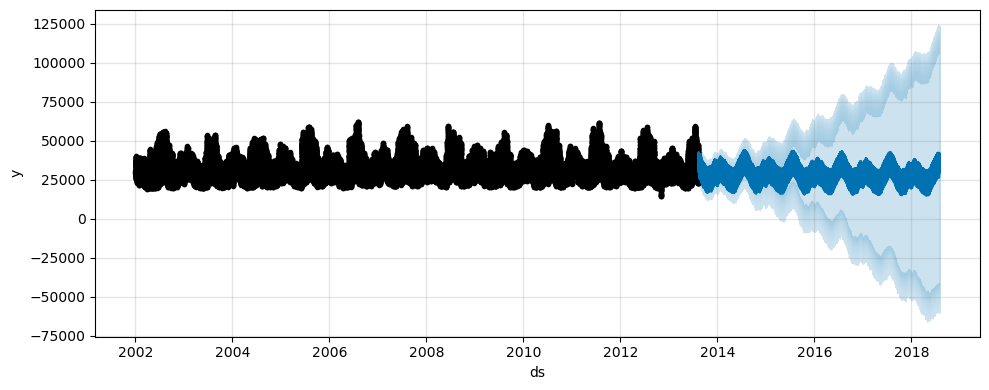

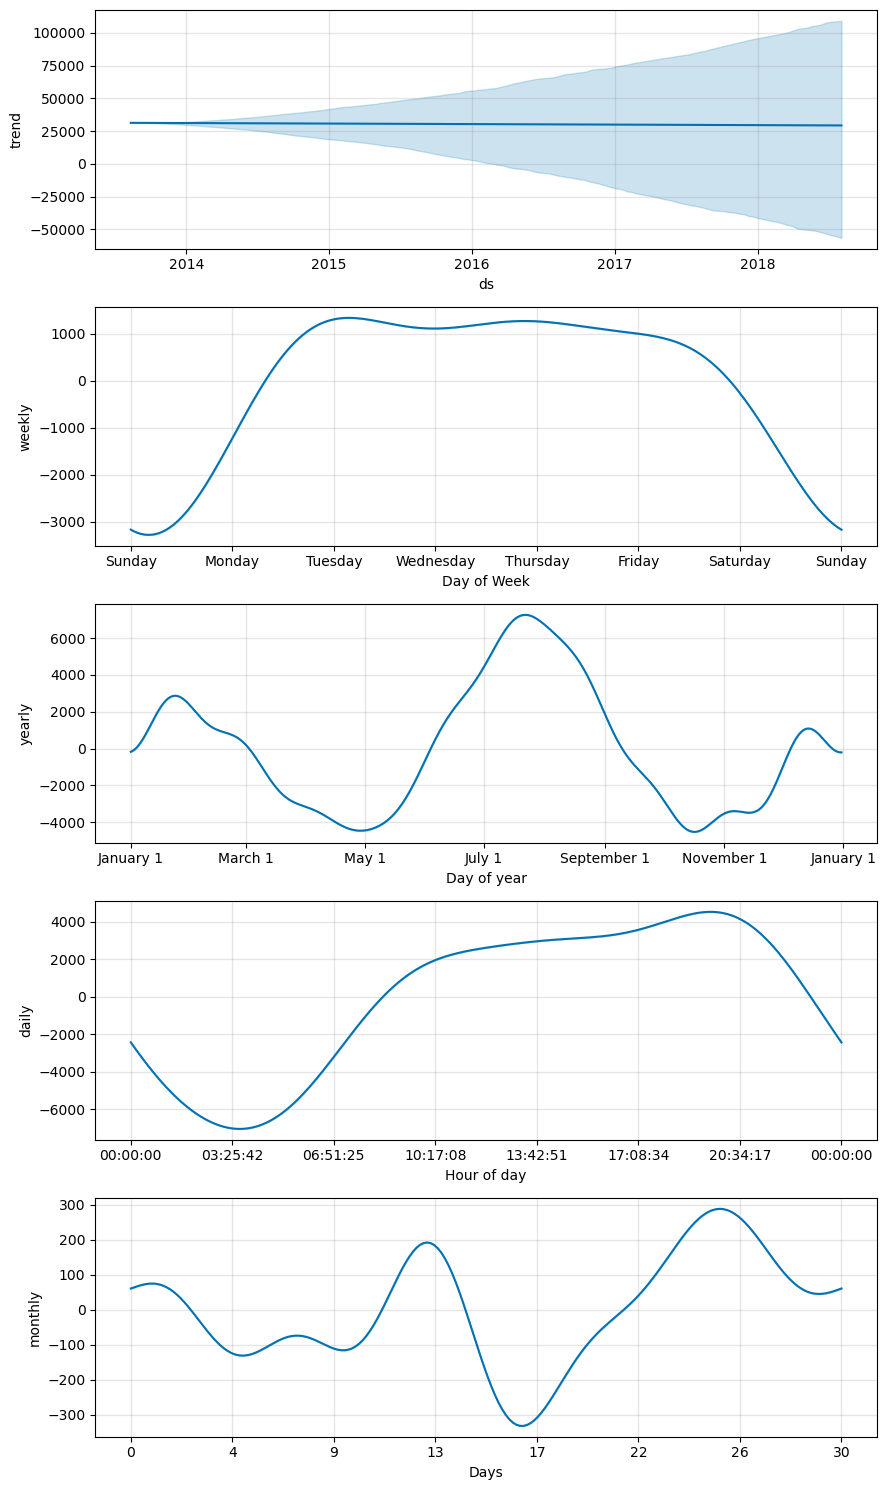

In [84]:
### We know there is monthly seasonality so we add to our model and see 
## Using hourly power consumption
model_prophet=Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
model_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=6)
model_prophet.fit(tr_df)
future=model_prophet.make_future_dataframe(periods=len(te_df), freq='H', include_history=False)
prediction=model_prophet.predict(future)
fig=model_prophet.plot(prediction, figsize=(10, 4))
display(prediction.head())
model_prophet.plot_components(prediction);

mse=17295764.714, rmse=4158.818, mae=3112.326, mape=0.097, smape=0.100


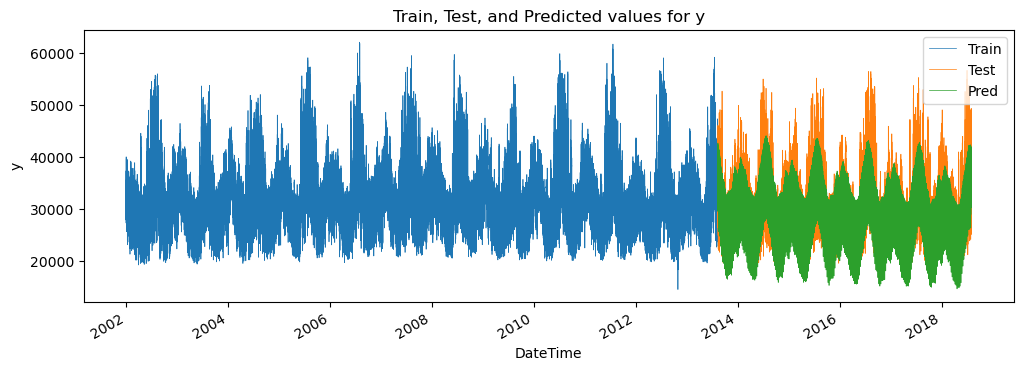

In [85]:
prediction.index=prediction.ds
plot_and_validate(tr_df, te_df, prediction, 'y', 'yhat')

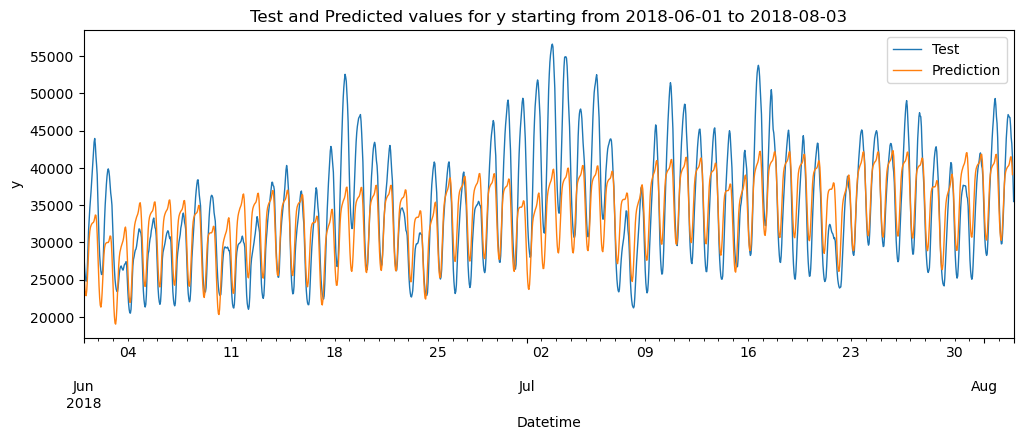

In [86]:
## We have a closer look (zoom in) on part of the predictions
te_df.loc['2018-06-01':]['y'].plot(legend=True, label='Test', linewidth=1)
prediction.loc['2018-06-01':]['yhat'].plot(legend=True, label='Prediction', linewidth=1)
# Adding y-axis label and title
plt.ylabel('y')
plt.xlabel('Datetime')
plt.title('Test and Predicted values for y starting from 2018-06-01 to 2018-08-03')
# Adding legend
plt.legend()
# Show plot
plt.show()

In [ ]:
##############################################################################################################################
#################                         PART II DEEP LEARNING                  #############################################
#################            LSTM MODEL OF HOURLY ENERGY CONSUMPTION             #############################################
##############################################################################################################################

In [24]:
# import relevant libraries 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
import time  # Import the time module
import random
import tensorflow as tf

# Call the time series data
ts = data

#SET seed for reproducibility
np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

# Splitting data into training, validation, and test sets
train_size = int(len(ts) * 0.7)
valid_size = int(len(ts) * 0.2)
test_size = len(ts) - train_size - valid_size

train, validation, test = ts[0:train_size], ts[train_size:train_size + valid_size], ts[train_size + valid_size:]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
validation_scaled = scaler.transform(validation.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

# Function to create dataset
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 24
X_train, y_train = create_dataset(train_scaled, look_back)
X_valid, y_valid = create_dataset(validation_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], look_back, 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], look_back, 1))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, 1))

# Set early stoppage when 3 consecutive loss are the same 
early_stopping = EarlyStopping(monitor='val_loss',patience=3, mode='min')
                                   
# Create and fit the LSTM network                                   
model = Sequential()
model.add(LSTM(32, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics='MeanAbsoluteError')
# Record the start time
start_time = time.time()
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, shuffle=True, callbacks=[early_stopping], validation_data=(X_valid, y_valid))
# Record the end time
end_time = time.time()

# Calculate and print the training time
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Epoch 1/50
3180/3180 [==============================] - 31s 9ms/step - loss: 0.0016 - mean_absolute_error: 0.0248 - val_loss: 2.6882e-04 - val_mean_absolute_error: 0.0133
Epoch 2/50
3180/3180 [==============================] - 31s 10ms/step - loss: 2.2063e-04 - mean_absolute_error: 0.0111 - val_loss: 1.3745e-04 - val_mean_absolute_error: 0.0085
Epoch 3/50
3180/3180 [==============================] - 31s 10ms/step - loss: 1.8529e-04 - mean_absolute_error: 0.0100 - val_loss: 1.3609e-04 - val_mean_absolute_error: 0.0085
Epoch 4/50
3180/3180 [==============================] - 34s 11ms/step - loss: 1.7336e-04 - mean_absolute_error: 0.0096 - val_loss: 1.2644e-04 - val_mean_absolute_error: 0.0083
Epoch 5/50
3180/3180 [==============================] - 31s 10ms/step - loss: 1.4990e-04 - mean_absolute_error: 0.0089 - val_loss: 1.7709e-04 - val_mean_absolute_error: 0.0109
Epoch 6/50
3180/3180 [==============================] - 32s 10ms/step - loss: 1.2783e-04 - mean_absolute_error: 0.0082 - val_

In [25]:
# Shape of the different data
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((101732, 24, 1),
 (101732,),
 (29049, 24, 1),
 (29049,),
 (14513, 24, 1),
 (14513,))

454/454 [==============================] - 1s 3ms/step


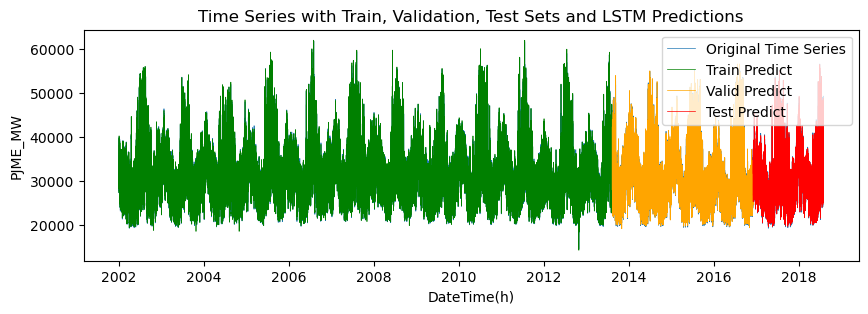

In [26]:
# Make predictions
train_predict = model.predict(X_train)
valid_predict = model.predict(X_valid)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
valid_predict = scaler.inverse_transform(valid_predict)
test_predict = scaler.inverse_transform(test_predict)

# Inverse transform the actual values
train_scaled = scaler.inverse_transform(train_scaled)
validation_scaled = scaler.inverse_transform(validation_scaled)
test_scaled = scaler.inverse_transform(test_scaled)

# Plotting the results
plt.figure(figsize=(10, 3))
plt.plot(ts, label='Original Time Series', linewidth=0.5)
plt.plot(ts.index[look_back:train_size], train_predict, label='Train Predict', color='green', linewidth=0.5)
plt.plot(ts.index[train_size+look_back:train_size+valid_size], valid_predict, label='Valid Predict', color='orange', linewidth=0.5)
plt.plot(ts.index[train_size+valid_size+look_back:], test_predict, label='Test Predict', color='red', linewidth=0.5)
plt.title('Time Series with Train, Validation, Test Sets and LSTM Predictions')
plt.xlabel('DateTime(h)')
plt.ylabel('PJME_MW')
plt.legend()
plt.show()

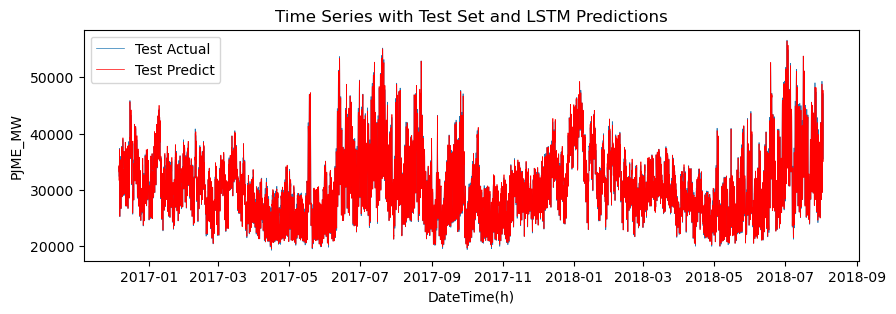

In [27]:
# Extract the original and predicted values for the test set
test_actual = test[look_back:].values  # Adjust the index to align with the predictions, alpha=0.
test_predicted = test_predict

# Plotting the results
plt.figure(figsize=(10, 3))
plt.plot(test.index[look_back:], test_actual, label='Test Actual', linewidth=0.5)
plt.plot(test.index[look_back:], test_predicted, label='Test Predict', color='red',  linewidth=0.5)
plt.title('Time Series with Test Set and LSTM Predictions')
plt.xlabel('DateTime(h)')
plt.ylabel('PJME_MW')
plt.legend()
plt.show()

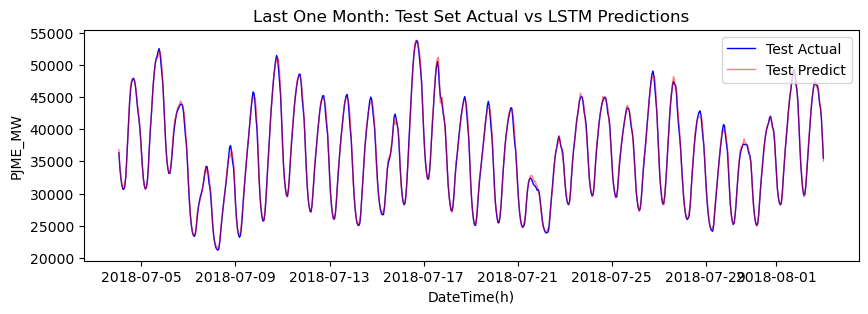

In [28]:
# Extract the last one month of the test set and its predictions
last_month_index = -720  # 720 hours in a month for hourly dataalpha=0.6,
test_last_month = test[look_back:][last_month_index:]
test_pred_last_month = test_predict[last_month_index:]

# Plotting the last one month of the test set and its predictions
plt.figure(figsize=(10, 3))
plt.plot(test_last_month.index, test_last_month.values, label='Test Actual', color='blue',  linewidth=1)
plt.plot(test_last_month.index, test_pred_last_month, label='Test Predict', color='red',  linewidth=1, alpha=0.5)#marker='x',
plt.title('Last One Month: Test Set Actual vs LSTM Predictions')
plt.xlabel('DateTime(h)')
plt.ylabel('PJME_MW')
plt.legend()
plt.show()

In [29]:
# Extract the original and predicted values for the test set
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
test_actual = test[look_back:].values  # Adjust the index to align with the predictions
test_predicted = test_predict

# Calculate MAE, RMSE, and MSE for the test set
mae = mean_absolute_error(test_actual, test_predicted)
mse = mean_squared_error(test_actual, test_predicted)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_actual, test_predicted)

print(f'MAE: {mae:.3f}')
print(f'MSE: {mse:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAPE: {mape:.3f}')

MAE: 283.420
MSE: 155579.446
RMSE: 394.436
MAPE: 0.009


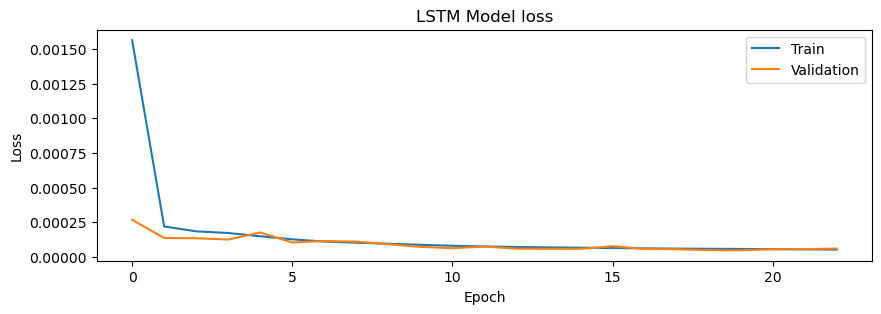

In [31]:
# Plot training & validation loss values
plt.figure(figsize=(10, 3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()